# Part 2-A - Application Design

How would you design and implement an application for a client? Feel free to make up a set of client objectives or use our suggestions below. Be as specific as possible on the software and systems you would use. Feel free to specify your assumptions on client implementation requirements.
- The client would like to predict what departments will experience significant turnover. 

### Questions to Answer 
In a scenario like the one above I would presume a descovery session would be held with the client. The descovery session would be used to answer questions like the following. 
1. How do they hope to action the prediction of the significant turnover in a department?
    1. Is the action automated, or informational for a human to action?
    1. If automated, what systems can be connected to and how can they be connected to?
1. Are there any current systems in place that does part of what is asked for?
1. What are the deployment preferences/guidlines to follow?
1. Is there an expectation of infrastructure "flavor" that will be expected to implement the solution? eg On-prem, AWS, GCP, Azure
1. What data is available for the application?
    1. Where does it come from? 
    1. How is it structured?
    1. How much data is it?
    1. How much new data is added and when?
1. What restrictions should we be aware of?
1. Who will recieve the hand off of the application?
1. etc.

### Assumptions
Lacking a discovery session the following assumptions are made.
- Survey data is not real time
- Data must be stored on the order of several years to provide trend reporting and model improvement
- Data regarding actual turnover is available
- Survey is provided by third party data collection
- Existing infrastructure can be leveraged
    - AWS, Data integration vendor, etc.
- Survey data does not currently need to be available with data from other systems
- Cost is not an issue

# Application Design 
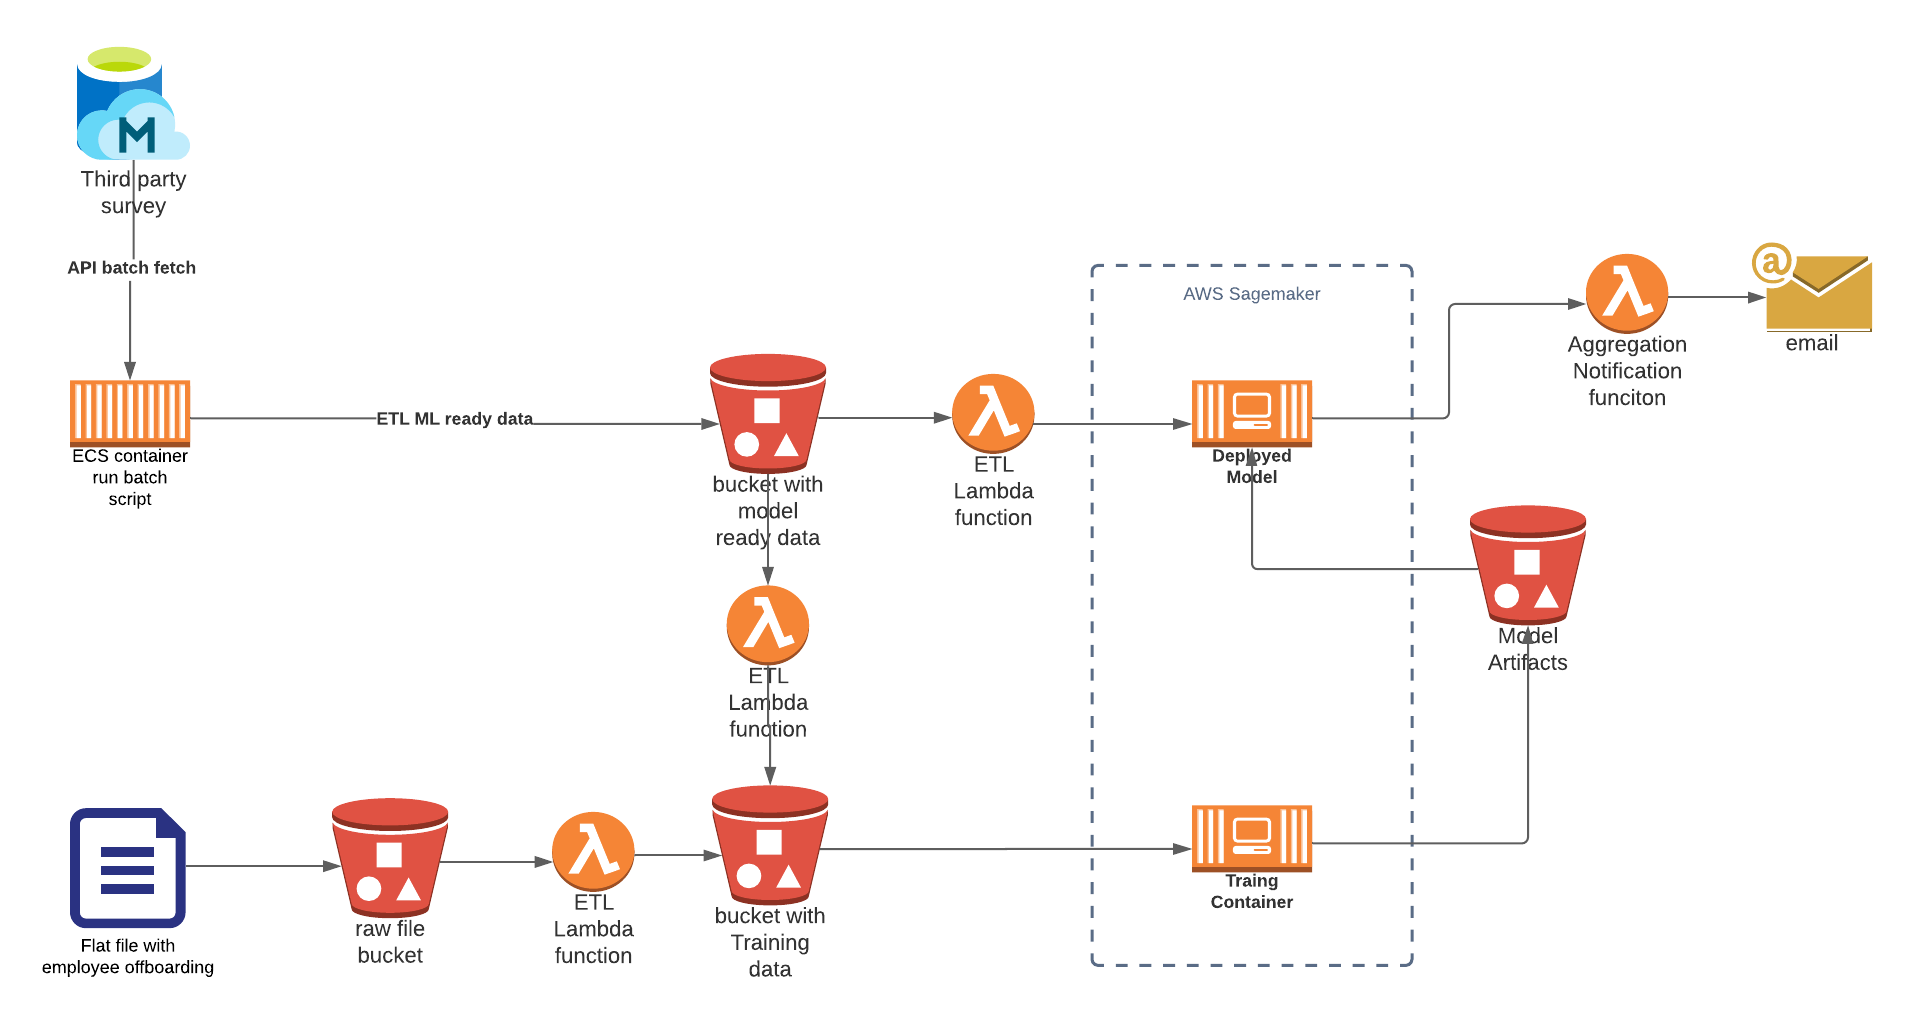

# Part 1 - Data Exploration

The folowing section describes the exploration of the data provided by the US Office of Personnel Management Federal Employee Viewpoint Survey. http://www.fedview.opm.gov/2015/EVSDATA/

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns


First, I attempt to load the data in to a dataframe and print out the first 10 rows. 

In [ ]:
raw_survey_data = pd.read_csv("./FEVS2015_PRDF_LGBT_CSV/evs2015_PRDF_LGBT.csv")

In [ ]:
# Print out the few rows of the data
raw_survey_data.head(10)

In [ ]:
raw_survey_data.tail(10)

In [ ]:
raw_survey_data.shape

## Notes on the Data
1. The columns of the data are broken up in to:
    1. demographic (column names start with the leter D) 
    1. survey data (column names start with the leter Q)
    1. A agency association data
    1. A random ID column
    1. a survey weight in column POSTWT 
1. There might be substantial missing data in a few of the columns. 

In [ ]:
fully_answered_survey_data = raw_survey_data.dropna()
fully_answered_survey_data.head()

In [ ]:
fully_answered_survey_data.shape

Looking at whats left the amount of data removed was very large. The data set went from 421748 to 1159 rows after removing all null values. Or in other words 1159 respondents filled out the entire survey. Depending on the desired fundamental questions being asked of the dataset, this subset of data could be used for comparison. However, for now we will try to maintian as much of the data as possible by focusing on removing columns with large amounts of null values. 

In [ ]:
# Get columns with total number of missing values
missing_value_counts = raw_survey_data.isna().sum()
print(missing_value_counts)

# Plot of the sum of the missing values
sns.histplot(data=raw_survey_data.isna().sum(), kde=False).set_title("Histogram of Missing Values in Each Column")
average_missing = raw_survey_data.isna().sum().mean()
standard_deviation = raw_survey_data.isna().sum().std()
print("Average missing values: %d" % raw_survey_data.isna().sum().mean())
print("Standard Deviation of missing values: %d" % raw_survey_data.isna().sum().std())

In [ ]:
# Get columns with total number of missing values
missing_value_counts = raw_survey_data.isna().sum()
print(missing_value_counts)

# Plot of the sum of the missing values a Box Plot
sns.boxplot(data=raw_survey_data.isna().sum(), orient='horizontal').set_title("Boxplot of Missing Values in Each Column")
average_missing = raw_survey_data.isna().sum().mean()
standard_deviation = raw_survey_data.isna().sum().std()
print("Average missing values: %d" % raw_survey_data.isna().sum().mean())
print("Standard Deviation of missing values: %d" % raw_survey_data.isna().sum().std())
print("Total Missing: %d" % raw_survey_data.isna().sum().sum())

In [ ]:
print("Percent of Missing Values: {0:.2%}".format(raw_survey_data.isna().sum().sum() / 
                                                   (raw_survey_data.shape[0] * raw_survey_data.shape[1]) ))

Through inspection of the histogram and boxplot it can be seen that many of the columns have the majority of questions answered. Removing columns with twice the standard deviation 

In [ ]:
keep_columns = missing_value_counts[missing_value_counts < 2 * standard_deviation]
keep_columns.shape

In [ ]:
# Remove the columns with large amounts of missing data
survey_data_reduced_columns = raw_survey_data[keep_columns.index.tolist()].copy()

sns.histplot(data=survey_data_reduced_columns.isna().sum(), kde=True).set_title(
    "Histogram of Missing Values in Each Column")
plt.show()

Now that the columns with the majority of missing data have been removed. We can replace records that have a missing value. However, I want to be sure dropping the records does not introduce a bias. To accomplish this we will replace missing categorical values with 'missing_\<column_name\>'. 


In [ ]:
# Gather and separate Demographic columns from Survey columns based on dtype of column
object_columns = [columns for columns in survey_data_reduced_columns.columns 
                  if survey_data_reduced_columns[columns].dtype == "object"]
survey_object_columns = [column for column in object_columns if column[0]== 'Q']
demographic_columns = [column for column in object_columns if column[0] != 'Q']

In [ ]:
# Fill null values and Validate all Demographic columns have a consistant datatype
for column in object_columns:
    # Fill in Null values with 'missing_<column_name>'
    survey_data_reduced_columns[column].replace(to_replace={np.nan: 'missing_%s' % column}, inplace=True)

# Validate all Demographic columns have a consistant datatype
for column in demographic_columns:
    record_types = survey_data_reduced_columns[column].map(type)
    print(record_types[~(record_types == str)])
    print(survey_data_reduced_columns[column].unique())
    

It appears the demographic columns now all have record types of type string and are consistant in the values that are present. 

In [ ]:
print(survey_data_reduced_columns.Q1.iloc[0], type(survey_data_reduced_columns.Q1.iloc[0]))
print(survey_data_reduced_columns[survey_object_columns[0]].iloc[0], 
      type(survey_data_reduced_columns[survey_object_columns[0]].iloc[0]))

### Note: 
Looks like survey columns are of mixed types and some columns are ints set as strings. In the interest of time we can regard these columns as being label encoded. However we now need to address any missing values in the non object type columns. 

In [ ]:
# Gather and separate Survey columns from non object columns based on first letter of column
not_object_columns = list(set(survey_data_reduced_columns.columns) - set(object_columns))
survey_encoded_columns = [column for column in not_object_columns if column[0]== 'Q']
numeric_demographic_columns = [column for column in not_object_columns if column[0] != 'Q']
print(survey_encoded_columns)
print(numeric_demographic_columns)

In [ ]:
# Check for dtype of each column for appropriate replacement of NA
survey_data_reduced_columns[not_object_columns].info()
survey_data_reduced_columns[not_object_columns].isna().sum()

# Replace missing values in non object columns can ignore
replacements = {k:{np.nan:-1} for k in not_object_columns}
survey_data_reduced_columns.replace(to_replace=replacements, inplace=True)

# Count of na in each column
survey_data_reduced_columns[not_object_columns].isna().sum()
print("Total null values in data: %d" % survey_data_reduced_columns.isna().sum().sum())

# Check uniqueness of RANDOM2 column 
print("Are values in RANDOM2 column unique?", 
      survey_data_reduced_columns['RANDOM2'].unique().shape[0] == survey_data_reduced_columns.shape[0])

In [ ]:
survey_data_reduced_columns.isna().sum().sum()

With no more Null values the data is ready for the final steps for modeling. 

# Part 2-B - Data Prediction
The folowing section describes an attempt to predict the answer to the  of the data provided by the US Office of Personnel Management Federal Employee Viewpoint Survey. http://www.fedview.opm.gov/2015/EVSDATA/

In [ ]:
# Set random Id to Index instead of a column and separate weights
survey_data_reduced_columns.set_index('RANDOM2', inplace=True)
survey_weights = survey_data_reduced_columns['POSTWT'].copy()

# Gather predictive columns
predictive_columns = survey_encoded_columns + numeric_demographic_columns 
predictive_columns += demographic_columns + survey_object_columns
predictive_columns
for column in ['POSTWT', 'DLEAVING', 'RANDOM2']:
    predictive_columns.remove(column)

In [ ]:
columns_to_one_hot_swap = demographic_columns + survey_object_columns
columns_to_one_hot_swap.remove('DLEAVING')

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix

In [ ]:
# To follow convention set dataframe of predictors to 'X'
X = survey_data_reduced_columns[predictive_columns]

# Set DLEAVING as the target
y = survey_data_reduced_columns['DLEAVING']

# Apply label encoder to target values 'y'
label_encoder = LabelEncoder()
label_encoder.fit(survey_data_reduced_columns['DLEAVING'])
y = label_encoder.transform(y)

# Break off Test set from data 20% of total data
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=0)

# Break off further a Validation set from the train data 16% of total data
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train,
                                                      train_size=0.8, test_size=0.2,
                                                      random_state=0)

one_hot_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
OH_X_train = pd.DataFrame(one_hot_encoder.fit_transform(X_train[columns_to_one_hot_swap]))
OH_X_train.index = X_train.index
num_X_train = X_train.drop(columns_to_one_hot_swap, axis=1)
OH_X_train = pd.concat([num_X_train, OH_X_train], axis=1)


linear_svc = SGDClassifier()


linear_svc.fit(OH_X_train, y_train)



### Scoring the model

In [ ]:
OH_X_valid = pd.DataFrame(one_hot_encoder.fit_transform(X_valid[columns_to_one_hot_swap]))
OH_X_valid.index = X_valid.index
num_X_valid = X_valid.drop(columns_to_one_hot_swap, axis=1)
OH_X_valid = pd.concat([num_X_valid, OH_X_valid], axis=1)

preds = linear_svc.predict(OH_X_valid)
print(accuracy_score(y_valid, preds))

plot_confusion_matrix(linear_svc, OH_X_valid, y_valid, display_labels=list(label_encoder.classes_))
plt.show() 

### Testing the model

In [ ]:
OH_X_test = pd.DataFrame(one_hot_encoder.fit_transform(X_test[columns_to_one_hot_swap]))
OH_X_test.index = X_test.index
num_X_test = X_test.drop(columns_to_one_hot_swap, axis=1)
OH_X_test = pd.concat([num_X_test, OH_X_test], axis=1)

preds = linear_svc.predict(OH_X_test)
print(accuracy_score(y_test, preds))

plot_confusion_matrix(linear_svc, OH_X_test, y_test, display_labels=list(label_encoder.classes_))
plt.show() 

### Trying out Gradient Boosting Classifier

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

In [ ]:
xgboost = GradientBoostingClassifier()


xgboost.fit(OH_X_train, y_train)

In [ ]:
preds = xgboost.predict(OH_X_valid)
print(accuracy_score(y_valid, preds))

plot_confusion_matrix(xgboost, OH_X_valid, y_valid, display_labels=list(label_encoder.classes_))
plt.show() 

In [ ]:
preds = xgboost.predict(OH_X_test)
print(accuracy_score(y_test, preds))

plot_confusion_matrix(xgboost, OH_X_test, y_test, display_labels=list(label_encoder.classes_))
plt.show() 